In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import custom_ts_length

#Ignore warnings for now 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Models
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.interval_based import DrCIF
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.padder import PaddingTransformer

/export/sphere/ebirah/ko20929/miniconda3/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [59]:
### Checking original ts_freq TS lengths ________________________________________
#Directory containing all main experiment folders
core_path = '/export/sphere/ebirah/ko20929/RBD_files/notebooks/frequency_analysis/constructed_data/band_power_time_series/expt_dfs/'

folders = ['N1_customised_40_expt_files', 'N2_120_expt_files_v2', 'N3_82_expt_files', 'REM_19_expt_files', 'EC_8_expts',
           'N1_full_expts', 'N2_full_expts', 'N3_full_expts', 'REM_full_expts', 'EC_full_expts']

load_path = core_path + 'EC_full_expts/'

X_orig = pd.read_hdf(load_path + 'X.h5', key='df', mode='r')
y_orig = pd.read_hdf(load_path + 'y_full.h5', key='df', mode='r') 
groups_orig = pd.read_hdf(load_path + 'groups.h5', key='df', mode='r')

len(X_orig.iloc[0,1] )

16

In [8]:
#I run this code twice manually editing, once for the short lengths and once for the longer lengths

folder = '/export/sphere/ebirah/ko20929/RBD_using_custom_package/Data/'

dtypes =  ['Wake', 'N1', 'N2', 'N3','REM']
rows_to_drop = {'Wake' : 3 , 'N1': 1 , 'N2' : 6 , 'N3' : 0 , 'REM' : 0}
full_lengths = {}

results_dict = {}

#Folders to save the processed data to ___________
save_folders = ['freq_6_second_files_proc_short/' , 'freq_6_second_files_proc_long/' ]

#Length dictionaries for processing the data ________
short_lengths = {'Wake': 26, 'N1': 125, 'N2': 360, 'N3': 250, 'REM': 62}
full_lengths = {'Wake': 53, 'N1': 575, 'N2': 2505, 'N3': 1340, 'REM': 955}
full_ish_lengths = {'Wake': 53, 'N1': 500, 'N2': 2000, 'N3': 1000, 'REM': 800}

#Set the length dictionary and the save folder for the loop (change this manually for each running of this code)
save_folder = folder + 'freq_6_second_files_proc_short/'
length_dict = short_lengths

save_folder = folder + 'freq_6_second_files_proc_long/'
length_dict = full_ish_lengths

for data_type in dtypes:
    results_dict[data_type] = {}
        
    X = pd.read_hdf(folder + 'freq_6_second_files/' + data_type + 'six_second_freq_df.h5' , key = 'df', mode = 'r')
    y = pd.read_hdf(folder + 'freq_6_second_files/' + data_type + '_y.h5' , key = 'df', mode = 'r')
    groups = pd.read_hdf(folder + 'freq_6_second_files/' + data_type + '_groups.h5' , key = 'df', mode = 'r')
    
    #Merge y and groups into X
    X['y'] = y
    X['groups'] = groups
    
    #Add length , sort by it and drop length column
    X = custom_ts_length.add_ts_length(X)
    X = X.sort_values(by = ['ts_length'], ascending = True)
    
    n_rows_to_drop = rows_to_drop[data_type]
    X = X.iloc[n_rows_to_drop: , :]
    
    full_lengths[data_type] = X['ts_length'].max()
    
    X = X.drop(columns = ['ts_length'])
    
    #Recreate groups and y from X , then drop groups and y from X
    groups = X['groups']
    y = X['y']
    X = X.drop(columns = ['groups', 'y'])
    
    #Trim the X to the apporpriate length
    new_ts_length = length_dict[data_type]
    X = custom_ts_length.customise_df_ts_length(X, new_length = new_ts_length)
    
    #Save them to the appropriate folder 
    X.to_hdf(save_folder + data_type + '_X.h5' , key = 'df', mode = 'w')
    y.to_hdf(save_folder + data_type + '_y.h5' , key = 'df', mode = 'w')
    groups.to_hdf(save_folder + data_type + '_groups.h5' , key = 'df', mode = 'w')
    
    
    # Assign X, y , groups to the appropriate slot in the dictionary
    results_dict[data_type]['X'] = X
    results_dict[data_type]['groups'] = groups
    results_dict[data_type]['y'] = y
    
    print(custom_ts_length.check_ts_lengths(X))
    

/tmp/ipykernel_2797777/1567394123.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Delta_Central', 'Theta_Central', 'Alpha_Central', 'Sigma_Central',
       'Beta_Central', 'Gamma_Central', 'TotalAbsPow_Central', 'Delta_Frontal',
       'Theta_Frontal', 'Alpha_Frontal', 'Sigma_Frontal', 'Beta_Frontal',
       'Gamma_Frontal', 'TotalAbsPow_Frontal', 'Delta_Left Central',
       'Theta_Left Central', 'Alpha_Left Central', 'Sigma_Left Central',
       'Beta_Left Central', 'Gamma_Left Central', 'TotalAbsPow_Left Central',
       'Delta_Left Frontal', 'Theta_Left Frontal', 'Alpha_Left Frontal',
       'Sigma_Left Frontal', 'Beta_Left Frontal', 'Gamma_Left Frontal',
       'TotalAbsPow_Left Frontal', 'Delta_Left Parietal',
       'Theta_Left Parietal', 'Alpha_Left Parietal', 'Sigma_Left Parietal',
       'Beta_Left Parietal', 'Gamma_Left Parietal',
    

pass


/tmp/ipykernel_2797777/1567394123.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Delta_Central', 'Theta_Central', 'Alpha_Central', 'Sigma_Central',
       'Beta_Central', 'Gamma_Central', 'TotalAbsPow_Central', 'Delta_Frontal',
       'Theta_Frontal', 'Alpha_Frontal', 'Sigma_Frontal', 'Beta_Frontal',
       'Gamma_Frontal', 'TotalAbsPow_Frontal', 'Delta_Left Central',
       'Theta_Left Central', 'Alpha_Left Central', 'Sigma_Left Central',
       'Beta_Left Central', 'Gamma_Left Central', 'TotalAbsPow_Left Central',
       'Delta_Left Frontal', 'Theta_Left Frontal', 'Alpha_Left Frontal',
       'Sigma_Left Frontal', 'Beta_Left Frontal', 'Gamma_Left Frontal',
       'TotalAbsPow_Left Frontal', 'Delta_Left Parietal',
       'Theta_Left Parietal', 'Alpha_Left Parietal', 'Sigma_Left Parietal',
       'Beta_Left Parietal', 'Gamma_Left Parietal',
    

pass


/tmp/ipykernel_2797777/1567394123.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Delta_Central', 'Theta_Central', 'Alpha_Central', 'Sigma_Central',
       'Beta_Central', 'Gamma_Central', 'TotalAbsPow_Central', 'Delta_Frontal',
       'Theta_Frontal', 'Alpha_Frontal', 'Sigma_Frontal', 'Beta_Frontal',
       'Gamma_Frontal', 'TotalAbsPow_Frontal', 'Delta_Left Central',
       'Theta_Left Central', 'Alpha_Left Central', 'Sigma_Left Central',
       'Beta_Left Central', 'Gamma_Left Central', 'TotalAbsPow_Left Central',
       'Delta_Left Frontal', 'Theta_Left Frontal', 'Alpha_Left Frontal',
       'Sigma_Left Frontal', 'Beta_Left Frontal', 'Gamma_Left Frontal',
       'TotalAbsPow_Left Frontal', 'Delta_Left Parietal',
       'Theta_Left Parietal', 'Alpha_Left Parietal', 'Sigma_Left Parietal',
       'Beta_Left Parietal', 'Gamma_Left Parietal',
    

pass


/tmp/ipykernel_2797777/1567394123.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Delta_Central', 'Theta_Central', 'Alpha_Central', 'Sigma_Central',
       'Beta_Central', 'Gamma_Central', 'TotalAbsPow_Central', 'Delta_Frontal',
       'Theta_Frontal', 'Alpha_Frontal', 'Sigma_Frontal', 'Beta_Frontal',
       'Gamma_Frontal', 'TotalAbsPow_Frontal', 'Delta_Left Central',
       'Theta_Left Central', 'Alpha_Left Central', 'Sigma_Left Central',
       'Beta_Left Central', 'Gamma_Left Central', 'TotalAbsPow_Left Central',
       'Delta_Left Frontal', 'Theta_Left Frontal', 'Alpha_Left Frontal',
       'Sigma_Left Frontal', 'Beta_Left Frontal', 'Gamma_Left Frontal',
       'TotalAbsPow_Left Frontal', 'Delta_Left Parietal',
       'Theta_Left Parietal', 'Alpha_Left Parietal', 'Sigma_Left Parietal',
       'Beta_Left Parietal', 'Gamma_Left Parietal',
    

pass


/tmp/ipykernel_2797777/1567394123.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Delta_Central', 'Theta_Central', 'Alpha_Central', 'Sigma_Central',
       'Beta_Central', 'Gamma_Central', 'TotalAbsPow_Central', 'Delta_Frontal',
       'Theta_Frontal', 'Alpha_Frontal', 'Sigma_Frontal', 'Beta_Frontal',
       'Gamma_Frontal', 'TotalAbsPow_Frontal', 'Delta_Left Central',
       'Theta_Left Central', 'Alpha_Left Central', 'Sigma_Left Central',
       'Beta_Left Central', 'Gamma_Left Central', 'TotalAbsPow_Left Central',
       'Delta_Left Frontal', 'Theta_Left Frontal', 'Alpha_Left Frontal',
       'Sigma_Left Frontal', 'Beta_Left Frontal', 'Gamma_Left Frontal',
       'TotalAbsPow_Left Frontal', 'Delta_Left Parietal',
       'Theta_Left Parietal', 'Alpha_Left Parietal', 'Sigma_Left Parietal',
       'Beta_Left Parietal', 'Gamma_Left Parietal',
    

pass


In [4]:
    X.to_hdf(folder + data_type + 'six_second_freq_df.h5' , key = 'df', mode = 'w')
    groups.to_hdf(folder + data_type + '_groups.h5' , key = 'df', mode = 'w')
    y.to_hdf(folder + data_type + '_y.h5' , key = 'df', mode = 'w')

,Delta_Central,Theta_Central,Alpha_Central,Sigma_Central,Beta_Central,Gamma_Central,TotalAbsPow_Central,Delta_Frontal,Theta_Frontal,Alpha_Frontal,...,Gamma_Right Parietal,TotalAbsPow_Right Parietal,Delta_Right Temporal,Theta_Right Temporal,Alpha_Right Temporal,Sigma_Right Temporal,Beta_Right Temporal,Gamma_Right Temporal,TotalAbsPow_Right Temporal,check_lengths
38,0 0.456392 1 0.493814 2 0.51967...,0 0.363369 1 0.279351 2 0.27293...,0 0.125198 1 0.157818 2 0.13697...,0 0.025010 1 0.038717 2 0.03613...,0 0.026457 1 0.026169 2 0.03063...,0 0.003574 1 0.004131 2 0.00366...,0 24.359220 1 18.820673 2 18...,0 0.483011 1 0.322329 2 0.43589...,0 0.296202 1 0.388879 2 0.36481...,0 0.161104 1 0.215494 2 0.13086...,...,0 0.003277 1 0.004746 2 0.00359...,0 42.087070 1 29.120306 2 29...,0 0.417970 1 0.479695 2 0.42630...,0 0.321298 1 0.242500 2 0.26062...,0 0.149714 1 0.197318 2 0.20758...,0 0.044657 1 0.035317 2 0.03735...,0 0.052538 1 0.038625 2 0.05766...,0 0.013822 1 0.006546 2 0.01046...,0 21.663705 1 30.766068 2 20.12...,True
34,0 0.805676 1 0.654665 2 0.43311...,0 0.071621 1 0.121224 2 0.19950...,0 0.036242 1 0.042429 2 0.06139...,0 0.027292 1 0.029006 2 0.04596...,0 0.052163 1 0.132333 2 0.22766...,0 0.007006 1 0.020342 2 0.03236...,0 151.555343 1 74.619346 2 40...,0 0.800416 1 0.472526 2 0.38930...,0 0.070068 1 0.133221 2 0.20212...,0 0.016389 1 0.052787 2 0.05367...,...,0 0.002067 1 0.021382 2 0.01913...,0 2847.089791 1 179.490345 2 ...,0 0.940879 1 0.575703 2 0.51133...,0 0.013340 1 0.083367 2 0.18489...,0 0.013429 1 0.057795 2 0.04770...,0 0.007989 1 0.032915 2 0.04845...,0 0.019347 1 0.157191 2 0.18823...,0 0.005016 1 0.093030 2 0.01937...,0 378.274766 1 120.734682 2 23...,True
37,0 0.416122 1 0.545597 2 0.46580...,0 0.368202 1 0.315655 2 0.36786...,0 0.128019 1 0.096044 2 0.09566...,0 0.048452 1 0.019581 2 0.03373...,0 0.031874 1 0.019362 2 0.02958...,0 0.007331 1 0.003762 2 0.00735...,0 11.556274 1 18.332039 2 11.17...,0 0.441897 1 0.452046 2 0.60807...,0 0.359050 1 0.411103 2 0.23948...,0 0.091647 1 0.080000 2 0.07564...,...,0 0.014874 1 0.015819 2 0.02501...,0 24.125157 1 25.196902 2 13.21...,0 0.326926 1 0.439524 2 0.44495...,0 0.413741 1 0.377407 2 0.29494...,0 0.114125 1 0.056543 2 0.11075...,0 0.037283 1 0.043710 2 0.03500...,0 0.082656 1 0.056222 2 0.06709...,0 0.025269 1 0.026594 2 0.04724...,0 19.170169 1 29.930095 2 23.01...,True
64,0 0.751172 1 0.572066 2 0.55140...,0 0.103529 1 0.254530 2 0.19959...,0 0.071460 1 0.105147 2 0.12524...,0 0.035066 1 0.024258 2 0.06416...,0 0.033570 1 0.037580 2 0.05571...,0 0.005204 1 0.006420 2 0.00386...,0 59.192957 1 38.838585 2 58...,0 0.657062 1 0.695308 2 0.49426...,0 0.171360 1 0.186455 2 0.26177...,0 0.095183 1 0.058569 2 0.11206...,...,0 0.004927 1 0.008698 2 0.00573...,0 64.268630 1 32.523163 2 46.56...,0 0.684857 1 0.618116 2 0.59220...,0 0.136009 1 0.140619 2 0.19291...,0 0.105599 1 0.150105 2 0.13190...,0 0.026306 1 0.035384 2 0.04800...,0 0.033812 1 0.043970 2 0.03011...,0 0.013418 1 0.011805 2 0.00485...,0 30.068128 1 12.719667 2 27.43...,True
25,0 0.436396 1 0.615480 2 0.55761...,0 0.179146 1 0.162556 2 0.19106...,0 0.199191 1 0.095121 2 0.16435...,0 0.108092 1 0.070415 2 0.05486...,0 0.069479 1 0.048577 2 0.02950...,0 0.007696 1 0.007851 2 0.00259...,0 25.034416 1 40.310455 2 109...,0 0.510227 1 0.709345 2 0.64177...,0 0.182992 1 0.188858 2 0.18205...,0 0.169215 1 0.034624 2 0.11430...,...,0 0.007048 1 0.010216 2 0.00299...,0 26.617756 1 29.225138 2 95.71...,0 0.495554 1 0.387666 2 0.54446...,0 0.149504 1 0.186269 2 0.21912...,0 0.239431 1 0.309058 2 0.18175...,0 0.071948 1 0.053840 2 0.03454...,0 0.040778 1 0.059550 2 0.01863...,0 0.002785 1 0.003617 2 0.00146...,0 42.074257 1 45.335447 2 88.13...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,0 0.585892 1 0.389433 2 0.56760...,0 0.141087 1 0.199266 2 0.18226...,0 0.116468 1 0.153380 2 0.11038...,0 0.046958 1 0.116407 2 0.03469...,0 0.099722 1 0.130185 2 0.09905...,0

pass


<Axes: >

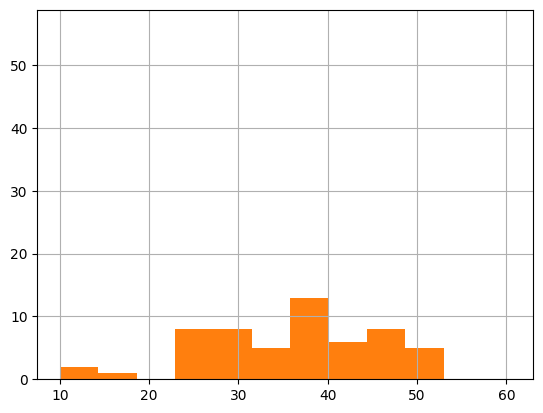

In [44]:
print(custom_ts_length.check_ts_lengths(X) )
# custom_ts_length.add_ts_length(X).ts_length.hist()
df_custom = custom_ts_length.customise_df_ts_length(X.iloc[:,:91], 60)
#Check the new lengths using histogram
custom_ts_length.add_ts_length(df_custom).ts_length.hist()
X.ts_length.hist()

In [46]:
#Using the Padding Transformer 
padded_clf = PaddingTransformer(pad_length = 53) * RocketClassifier(use_multivariate='yes')